# Cleaning loan data.

In [1]:
import db_utils as dbu
import pandas as pd
import numpy as np 
from scipy import stats
import matplotlib.pyplot as plt

Load raw data from csv

In [2]:
df = pd.read_csv('../data/loan_payments-raw.csv')
data_transform = dbu.DataTransform()
data_frame_transform = dbu.DataFrameTransform()
df_info = dbu.DataFrameInfo()
plotter = dbu.Plotter()

#%%[markdown]
# Inspecting the dataframe we see over 50000 entries for 44 columns
# Upon inspection, 'Unnamed: 0' duplicates the index, so we drop it.

In [3]:
df.info()
print(df['Unnamed: 0'].head(5))
df.drop(columns='Unnamed: 0', inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54231 entries, 0 to 54230
Data columns (total 44 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   54231 non-null  int64  
 1   id                           54231 non-null  int64  
 2   member_id                    54231 non-null  int64  
 3   loan_amount                  54231 non-null  int64  
 4   funded_amount                51224 non-null  float64
 5   funded_amount_inv            54231 non-null  float64
 6   term                         49459 non-null  object 
 7   int_rate                     49062 non-null  float64
 8   instalment                   54231 non-null  float64
 9   grade                        54231 non-null  object 
 10  sub_grade                    54231 non-null  object 
 11  employment_length            52113 non-null  object 
 12  home_ownership               54231 non-null  object 
 13  annual_inc      

From prior knowledge of the dataset, we expect columns to be a mixture of categorical, numerical, and dates.
We use the data_transform class to correct the dytpes.

In [4]:
categorical_columns = ['grade', 'sub_grade', 'employment_length', 'home_ownership','verification_status','loan_status','payment_plan','purpose','term', 'collections_12_mths_ex_med','inq_last_6mths','delinq_2yrs','inq_last_6mths', 'policy_code','application_type']
data_transform.MakeCategorical(df, categorical_columns)

datenum_columns = ['issue_date', 'earliest_credit_line', 'last_payment_date', 'next_payment_date', 'last_credit_pull_date']
data_transform.Dates2Datetimes(df, datenum_columns)

#%%[markdown]
# We also see that sseveral columns have null values.
# Four columns stand out with obviously high nan counts, and we drop these.
# Three columns have less than 1% NaN, so we drop rows from these
# We are left with columns that have too many missing values to drop either the rows or columns.

In [5]:
df_info.PrintNaNFractions(df)
data_frame_transform.DropColsWithNaN(df, ['mths_since_last_delinq',
                                          'mths_since_last_record',
                                          'next_payment_date',
                                          'mths_since_last_major_derog'])

data_frame_transform.DropRowsWithNaN(df, ['last_payment_date',
                                          'last_credit_pull_date',
                                          'collections_12_mths_ex_med'])

funded_amount has 5.544799100145673 % NaN.
term has 8.799395179878667 % NaN.
int_rate has 9.53144880234552 % NaN.
employment_length has 3.905515295679593 % NaN.
mths_since_last_delinq has 57.16656524865852 % NaN.
mths_since_last_record has 88.60245984768859 % NaN.
last_payment_date has 0.13460935627224282 % NaN.
next_payment_date has 60.12797108664786 % NaN.
last_credit_pull_date has 0.012907746491858899 % NaN.
collections_12_mths_ex_med has 0.09404215301211484 % NaN.
mths_since_last_major_derog has 86.17211557965001 % NaN.


In [6]:
ix = df[(df['home_ownership']=='NONE') | (df['home_ownership']=='OTHER')].index
df.drop(ix, inplace=True)
df['home_ownership'] = df['home_ownership'].cat.remove_unused_categories()    

df_info.PrintNaNFractions(df)

#%%[markdown] 
# We visualise these columns to impute these NaN thoughtfully.

funded_amount has 5.5407506107039755 % NaN.
term has 8.803390332371013 % NaN.
int_rate has 9.539936338737139 % NaN.
employment_length has 3.912206677030128 % NaN.


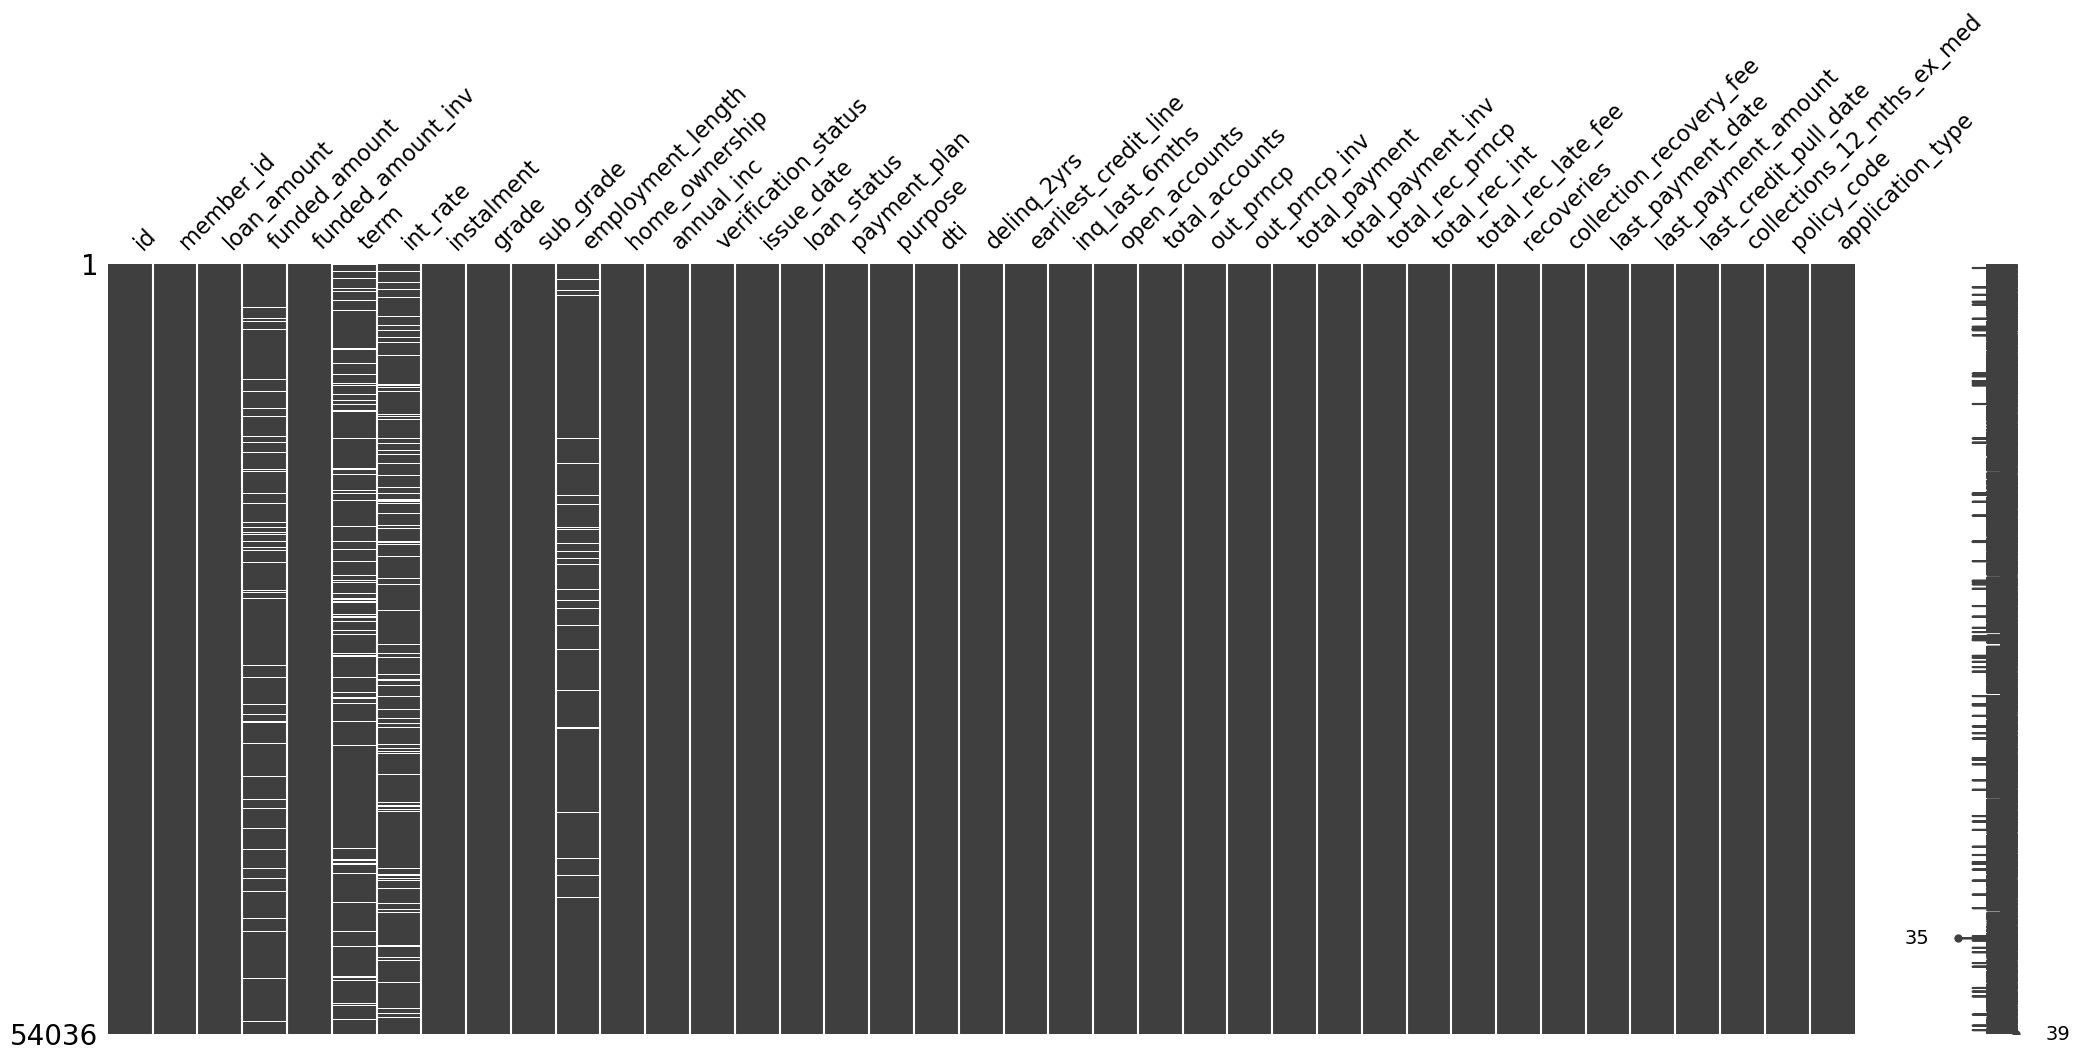

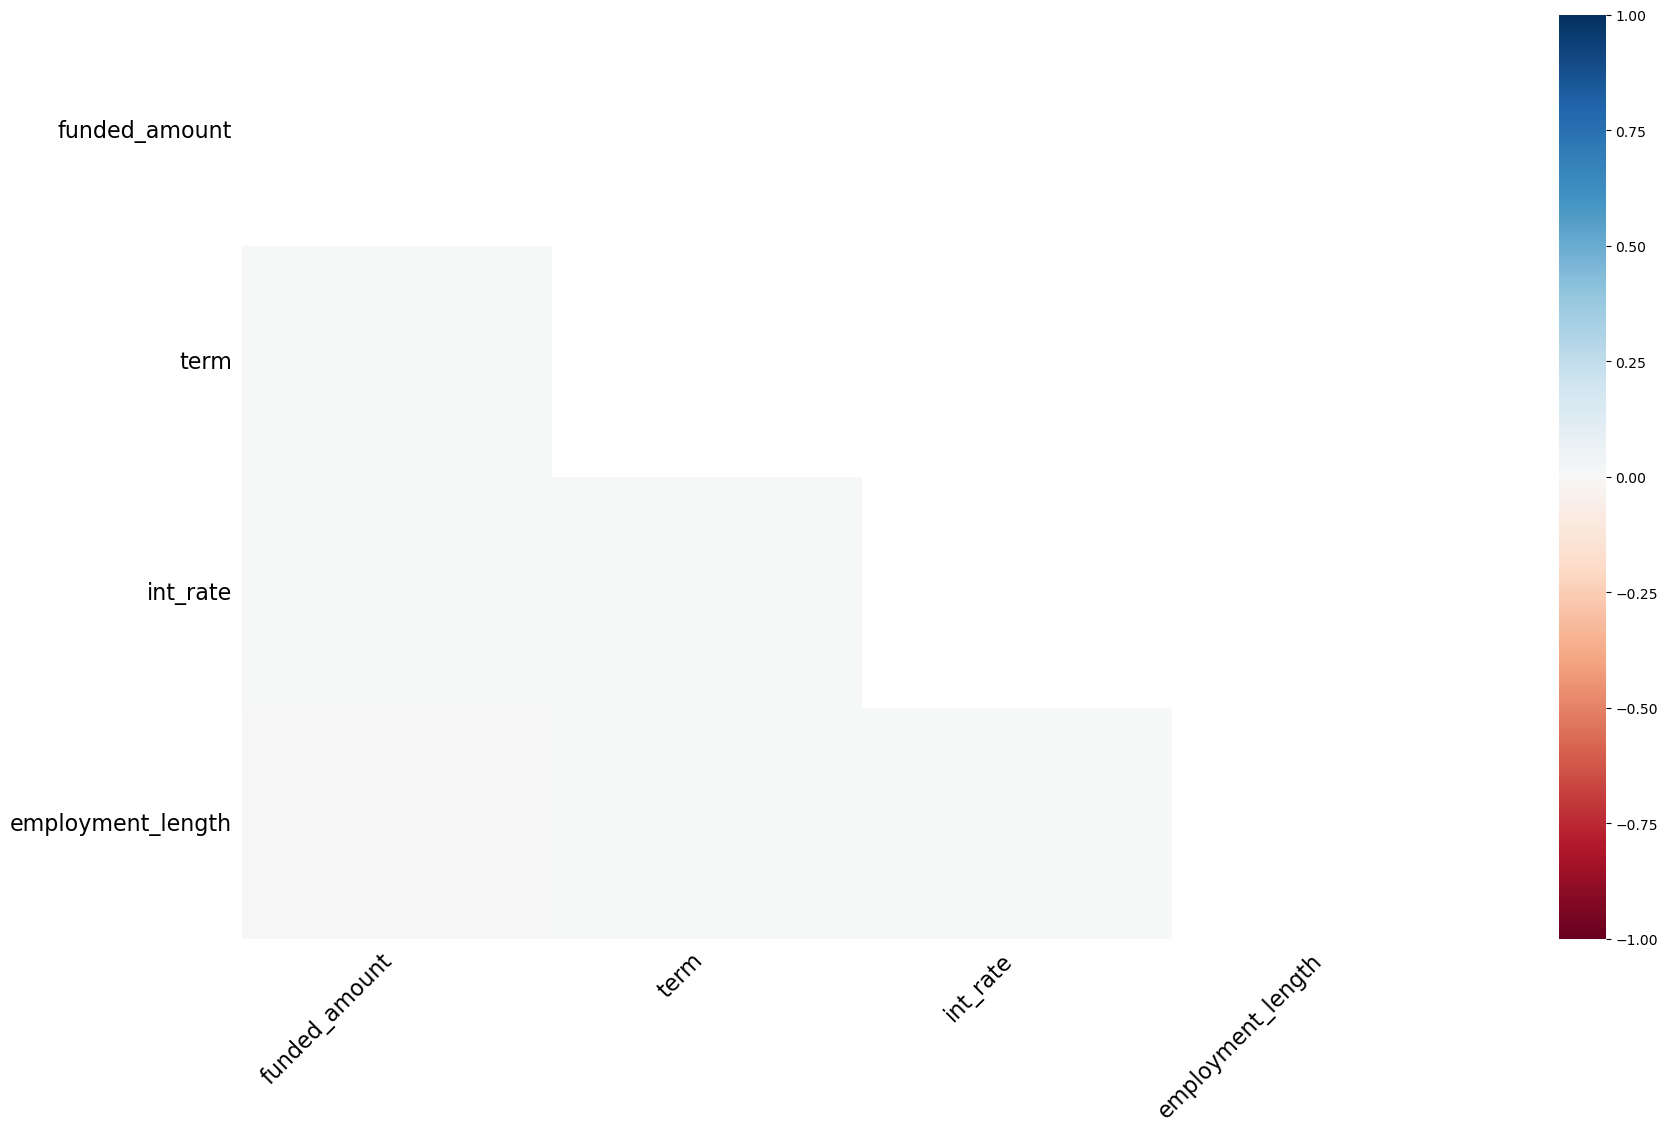

In [7]:
plotter.InspectNaN(df, ['matrix','heatmap'])

#%%[markdown]
# The NaN look uncorrelated accross the data, and a heatmap of the correlation confirms this.
# Next, we check the basic stats of each variable.

In [8]:
df_info.PrintColumnInfo(df, 'funded_amount')
df_info.PrintColumnInfo(df, 'term')
df_info.PrintColumnInfo(df, 'int_rate')
df_info.PrintColumnInfo(df, 'employment_length')

#%%[markdown]
# We check for correlations between the numerical variables, to see if we have options to impute by regression.

---------------------
funded_amount is a float64 with 54036 data, of which 5.5407506107039755 % are NaN.
The range of the data is 500.0 to 35000.0.
The mean is 13245.178480467066 with a standard deviation of 8018.330975513808.
The median is 12000.0, and the 25 and 75 % centiles are 7000.0 and 18000.0.
---------------------
---------------------
term is a category with 54036 data, of which 8.803390332371013 % are NaN.
There are 2 categories, of which 36 months is the most common at 66.03190465615515 % of the total.
---------------------
---------------------
int_rate is a float64 with 54036 data, of which 9.539936338737139 % are NaN.
The range of the data is 5.42 to 26.06.
The mean is 13.508490415498866 with a standard deviation of 4.395334930484905.
The median is 13.16, and the 25 and 75 % centiles are 10.37 and 16.2.
---------------------
---------------------
employment_length is a category with 54036 data, of which 3.912206677030128 % are NaN.
There are 11 categories, of which 10+ y

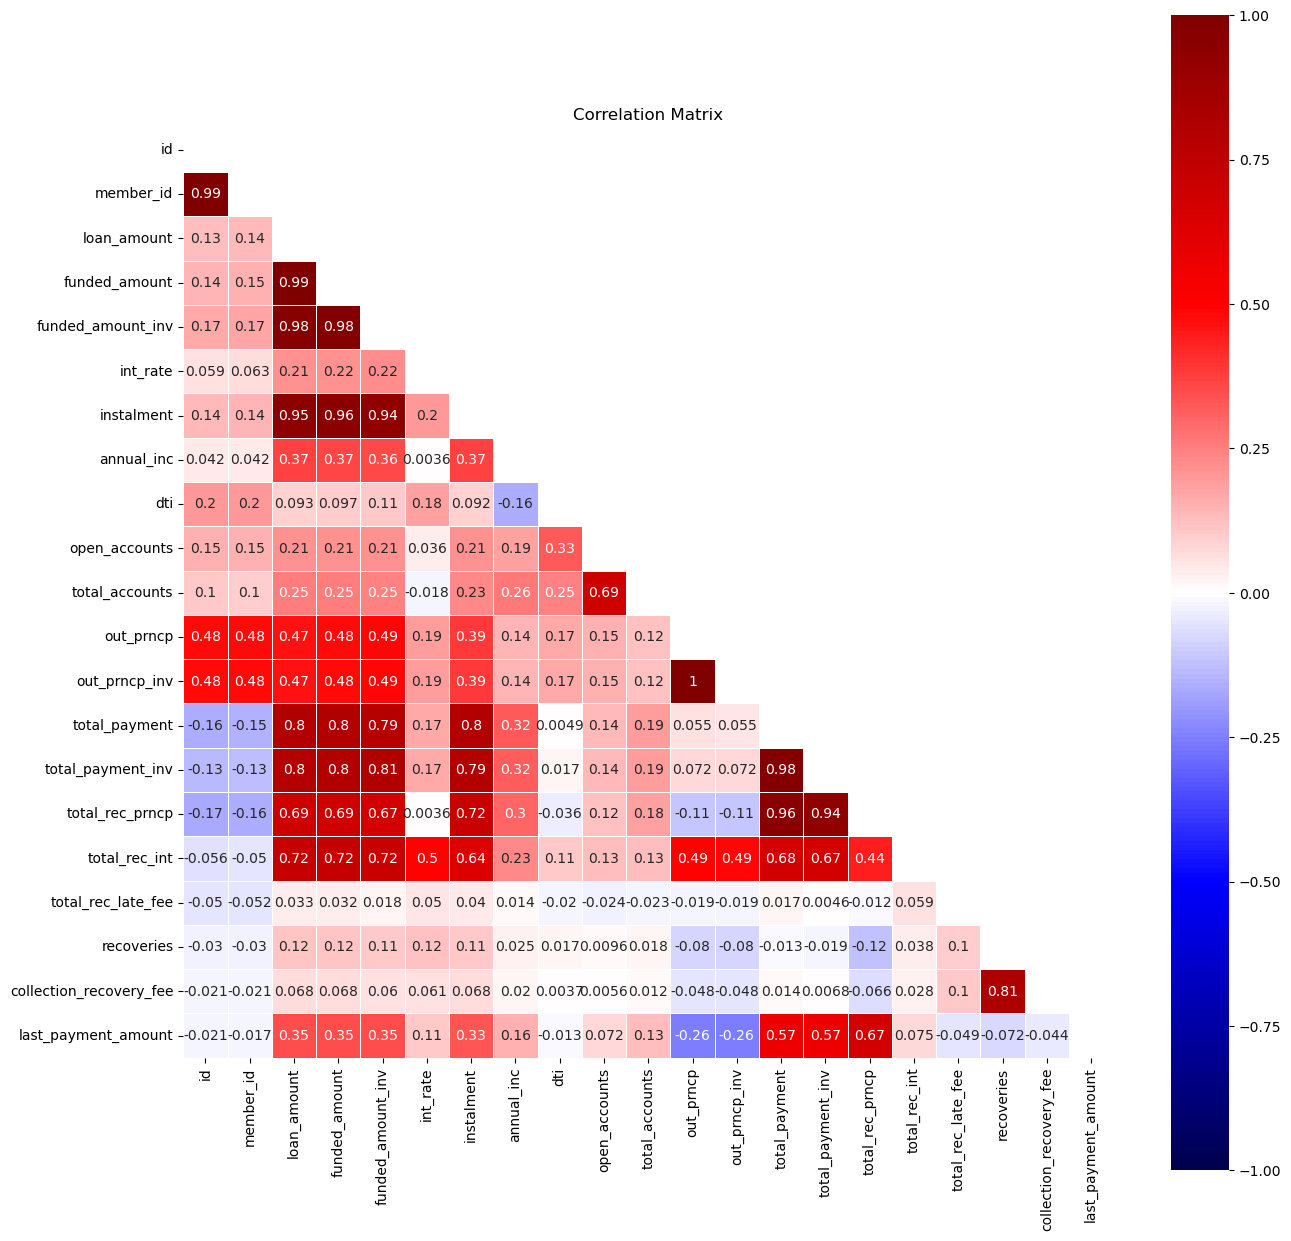

In [9]:
isnumeric = df_info.IsNumeric(df)
plotter.CorrelationHeatmap(df, isnumeric)

#%%[markdown]
# Interest rate is poorly correlated with all variables (max or around 0.5).
# We therefore impute this value with the median, which we see is similar to the mean.

In [10]:
data_frame_transform.ImputeNaN(df, 'int_rate', 'median')

#%%[markdown]
# employment_length has 11 categories, none of which are dominant. 
# We therefore add an 'Unknown' category, rather than potentially biasing by imputing.

In [11]:
data_frame_transform.ImputeNaN(df, 'employment_length', 'Unknown')

#%%[markdown]
# funded_amount is strongly correlated with funded_amount_inv and installment.
# We perform a multiple linear regression of 
# **funded_amount ~ 'funded_amount', 'funded_amount_inv', 'instalment','total_rec_int','total_rec_prncp','total_payment_inv','total_payment'**
# to impute the values.

/Users/max/Documents/aicore/projects/customer_loans/code/db_utils.py:245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column].loc[~mask] = mlr.predict(df[predictors].loc[~mask])


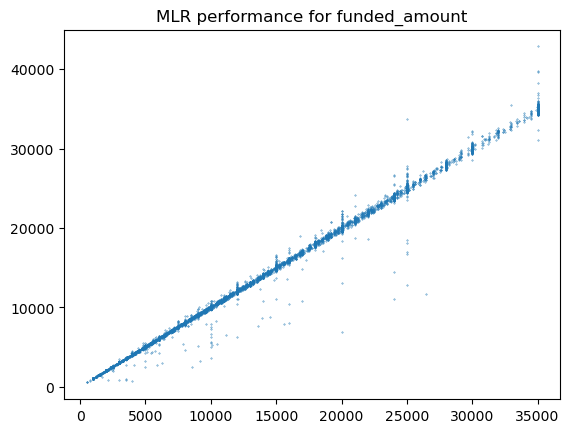

In [12]:
predictors = ['funded_amount_inv', 'instalment','total_rec_int','total_rec_prncp','total_payment_inv','total_payment']

mlr_mask = data_frame_transform.DefineMLR2Impute(df, 'funded_amount', predictors)

data_frame_transform.ImputeNaNMLR(df, 'funded_amount', predictors, mlr_mask)

# %%[markdown]
# term has two values, 36 months or 60 months. It is an important variable for later analysis.
# They have similar frequencies so imputing with the most common is risky.
# We therefore iteratively imputate term using a random forest method.

In [13]:
data_frame_transform.ImputeTerm(df)
df['term_numeric'] = [36 if ix == '36 months' else 60 for ix in df['term']]
data_transform.MakeCategorical(df,['term'])
#%%[markdown]
# Now we've dealt with all the NaN, so we reindex to clean up.

In [14]:
df_info.PrintNaNFractions(df)
df.reset_index(inplace=True)

#%%[markdown]
# Next we inspect the numerical data for skew. Where data are skewed away from normality, we test some transformations to reduce the skew.
# skews with magnitudes less than 0.5 are acceptable, between 0.5 and 1 are moderate, and greater than 1 are severely skewed.
#  

No NaN in dataset.


In [15]:
skew = df.skew(numeric_only=True) 
very_skewed = list(skew.index[abs(skew)>=1])
moderately_skewed = list(skew.index[(abs(skew)>=0.5) & (abs(skew)<1)])
all_skewed = list(skew.index[abs(skew)>=0.5])

print('Moderately skewed:')
print(moderately_skewed)
print('')
print('Very skewed:')
print(very_skewed)


#%%[markdown]
# We test log, box-cox, and yeo-johnson transformations on each skewed variable.
# The yeo-johnson transofrmation performs best in all cases where a transofrmation is reasonable.

Moderately skewed:
['loan_amount', 'funded_amount', 'funded_amount_inv', 'instalment', 'total_accounts']

Very skewed:
['id', 'member_id', 'annual_inc', 'open_accounts', 'out_prncp', 'out_prncp_inv', 'total_payment', 'total_payment_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_payment_amount', 'term_encoded', 'term_numeric']


Box-Cox fails for funded_amount_inv as some data are negative.
Returning original data.


Box-Cox fails for out_prncp as some data are negative.
Returning original data.


Box-Cox fails for out_prncp_inv as some data are negative.
Returning original data.


Box-Cox fails for total_payment_inv as some data are negative.
Returning original data.


Box-Cox fails for total_rec_prncp as some data are negative.
Returning original data.


Box-Cox fails for total_rec_late_fee as some data are negative.
Returning original data.


Box-Cox fails for recoveries as some data are negative.
Returning original data.


Box-Cox fails for collection_recovery_fee as some data are negative.
Returning original data.


Box-Cox fails for last_payment_amount as some data are negative.
Returning original data.


Box-Cox fails for term_encoded as some data are negative.
Returning original data.


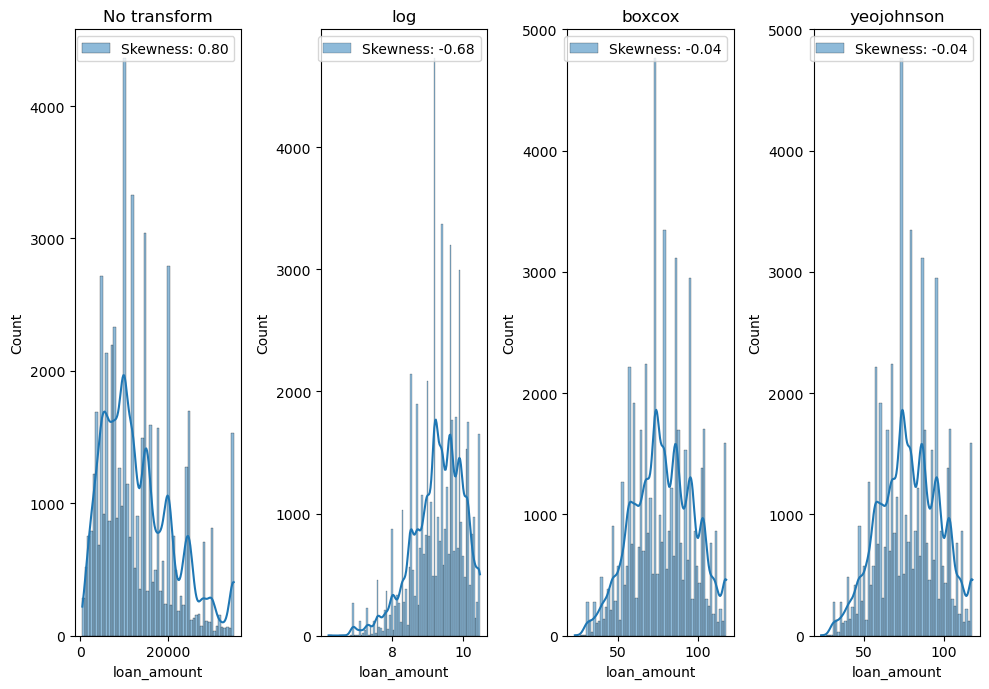

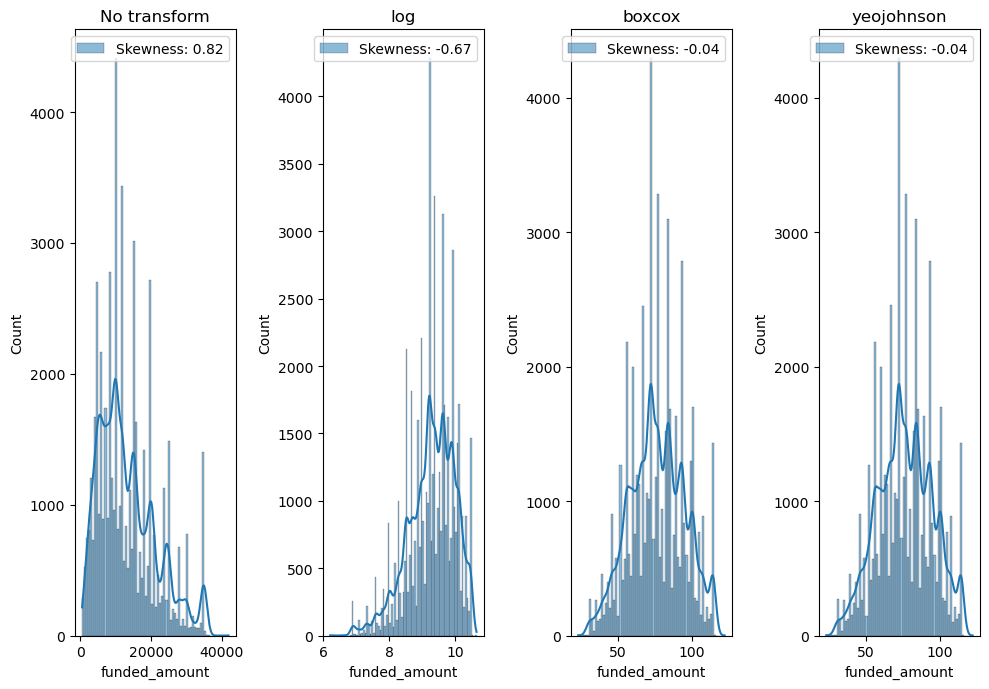

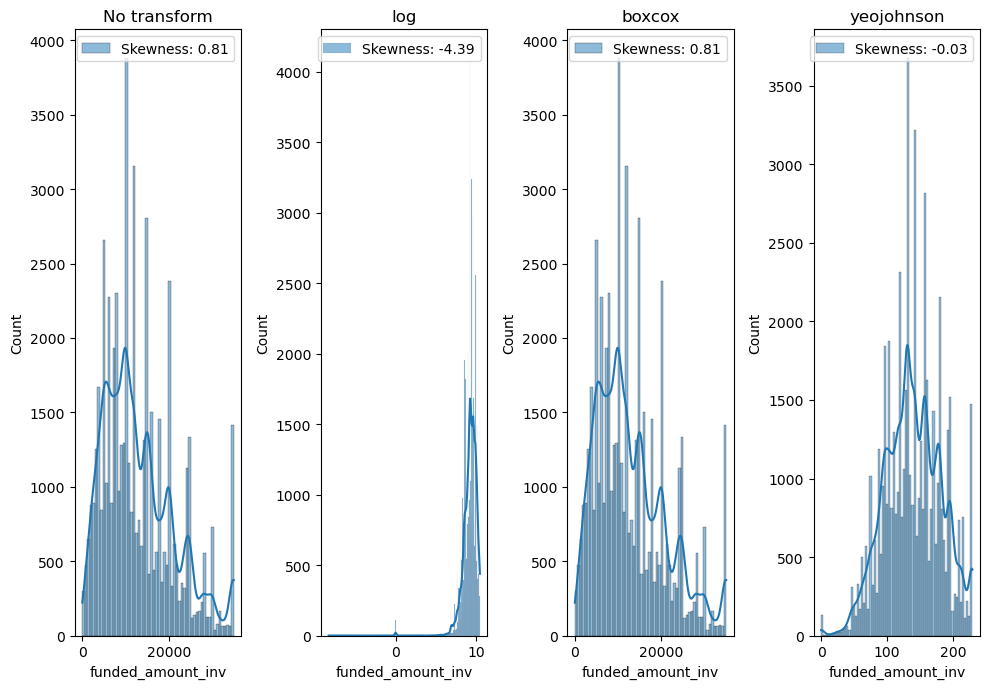

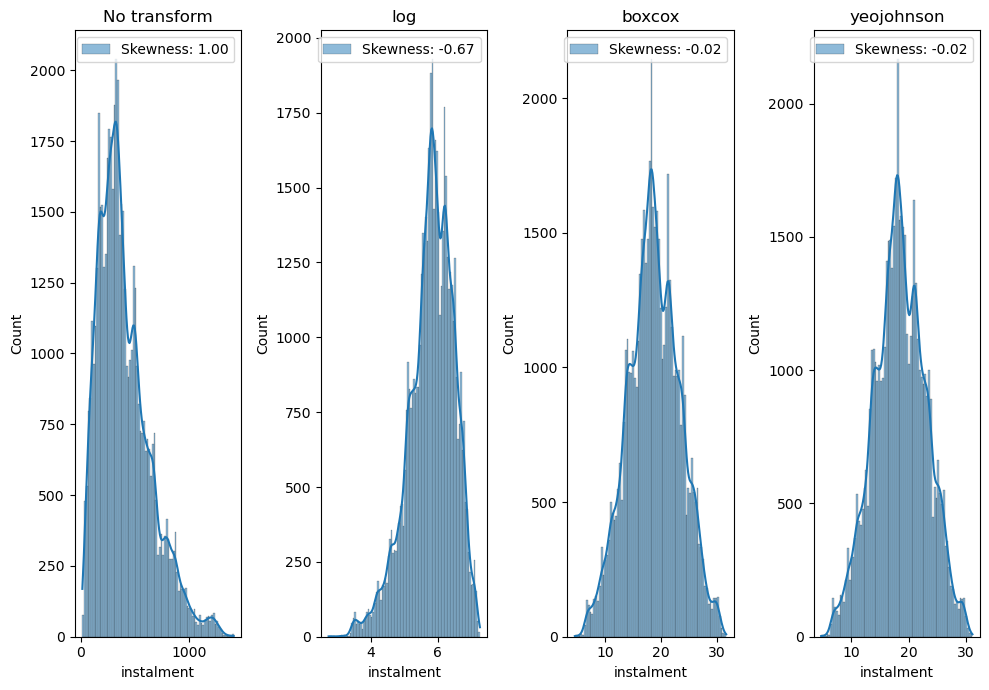

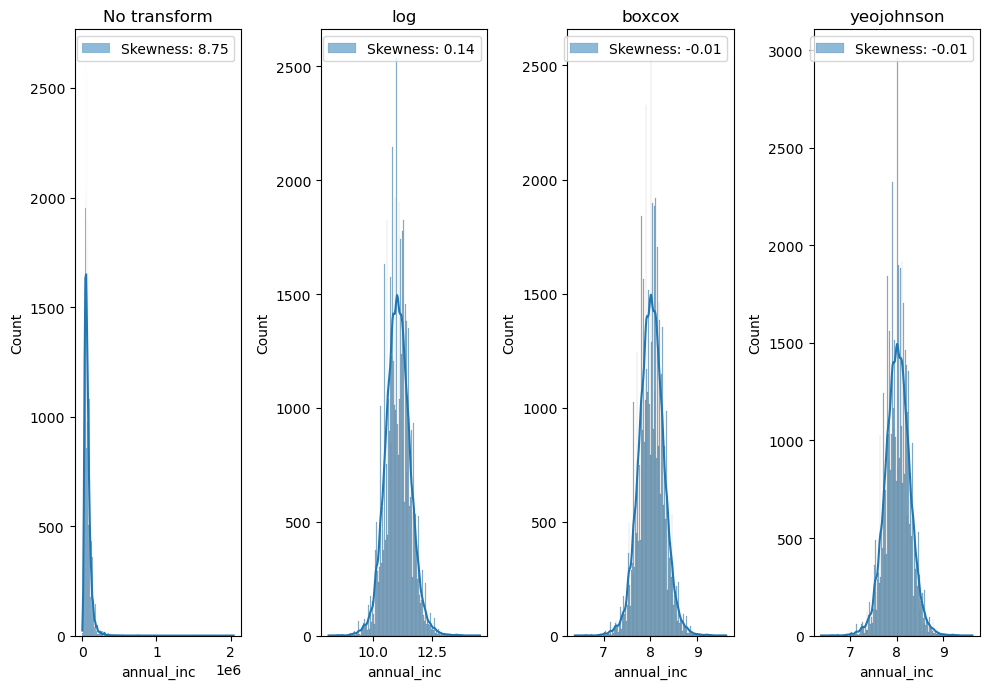

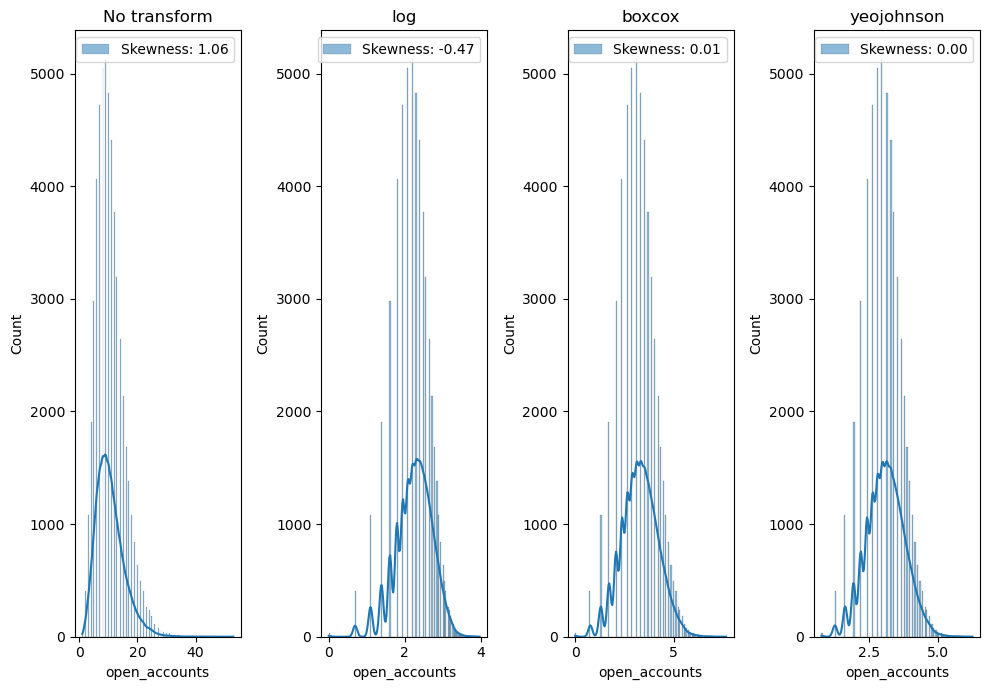

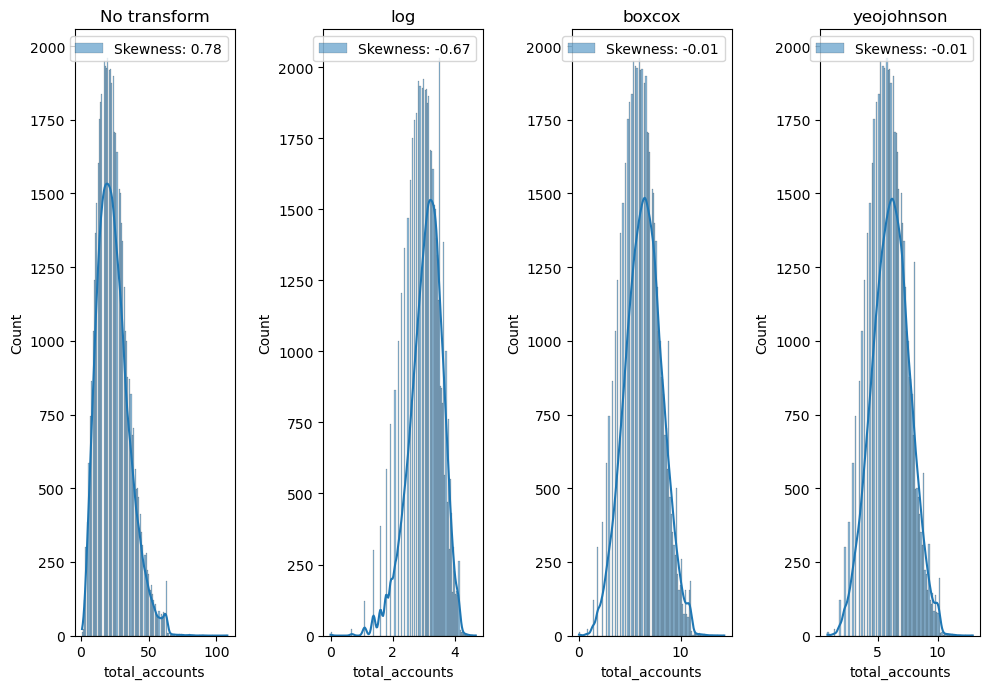

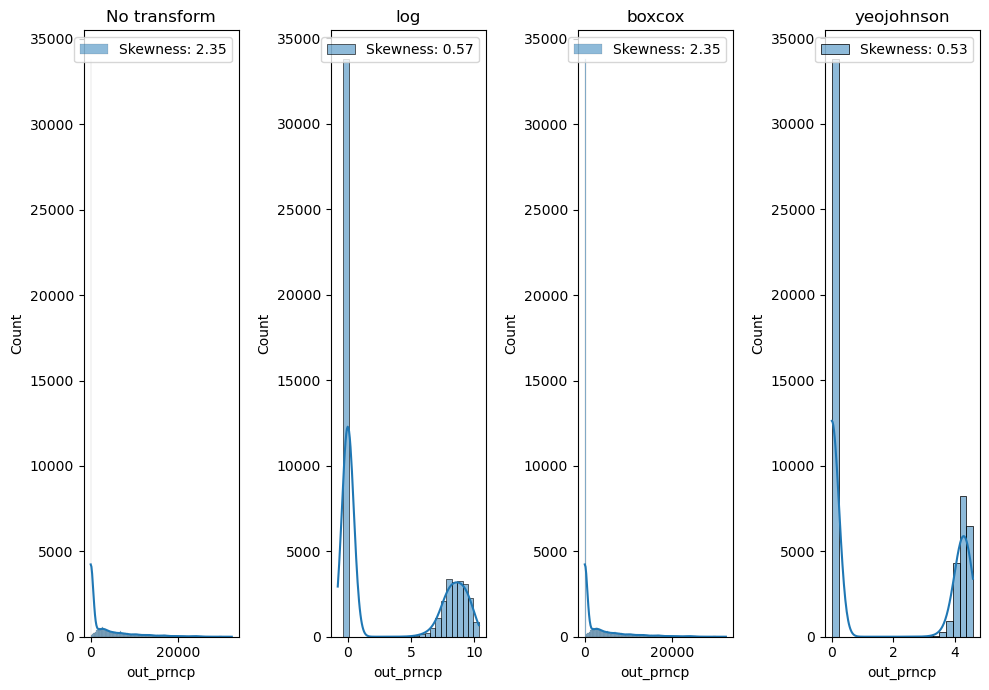

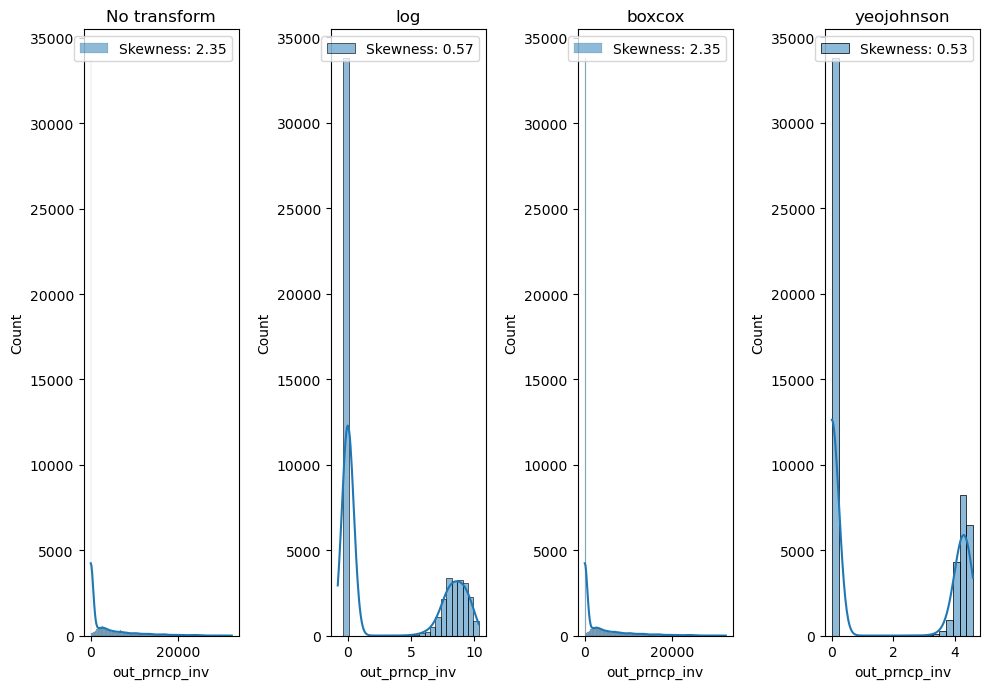

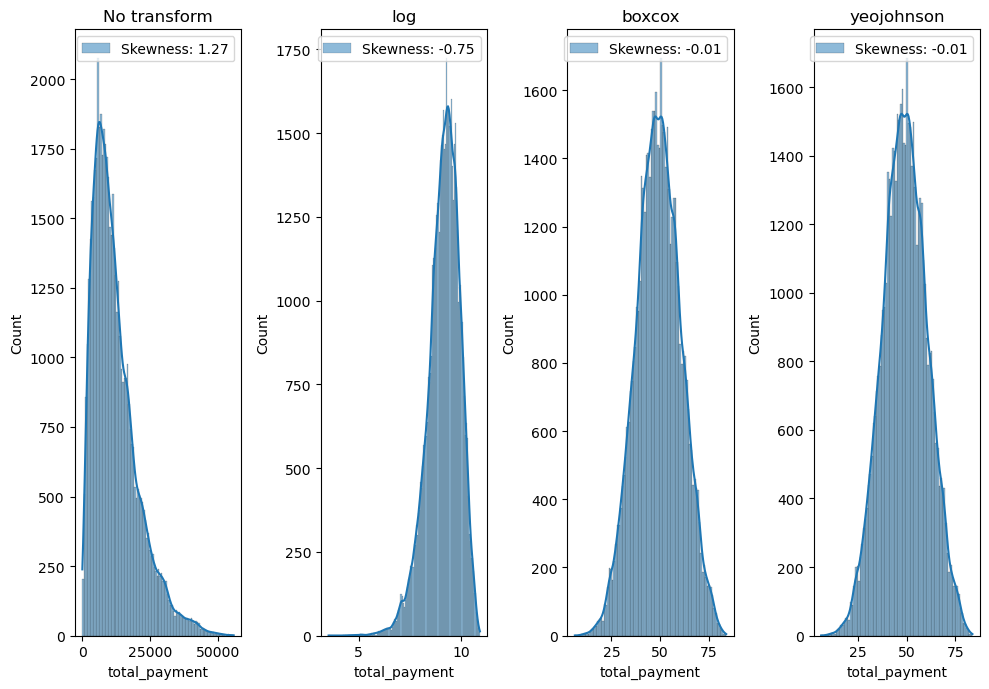

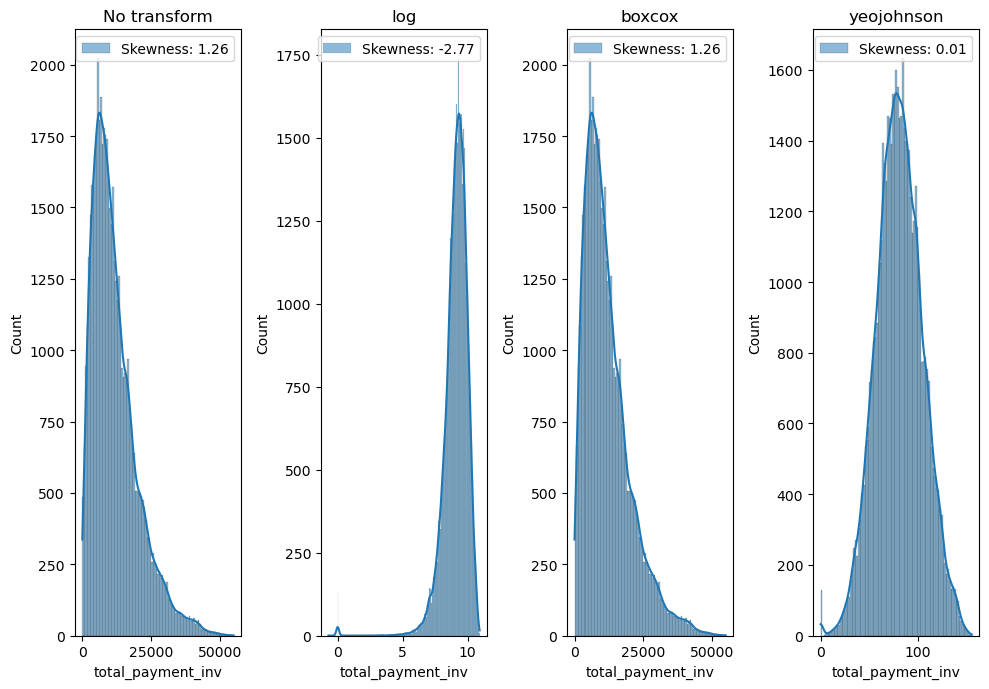

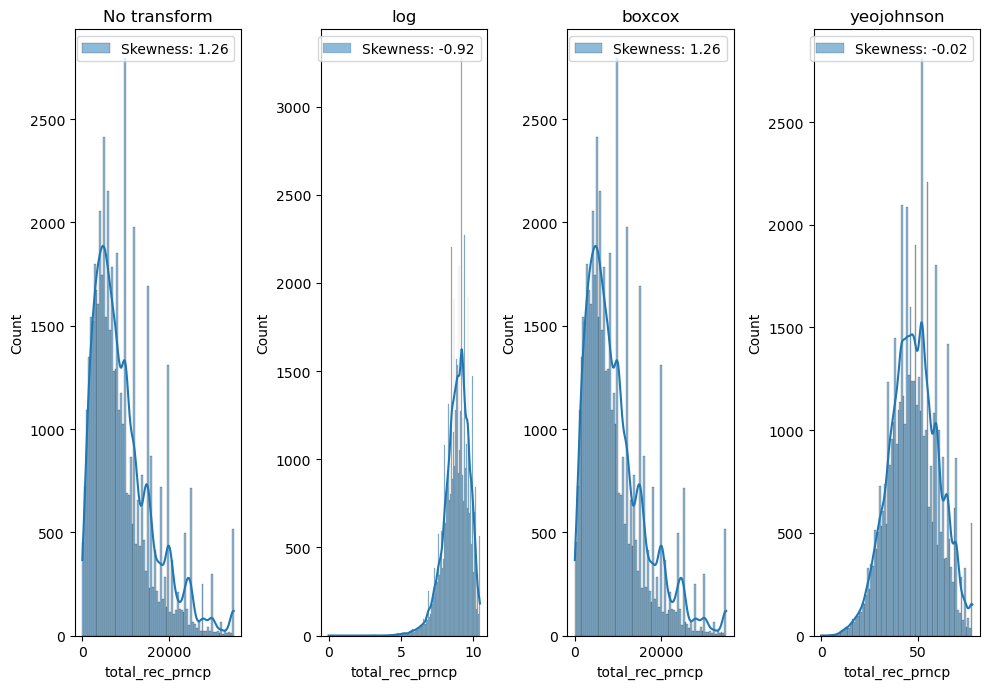

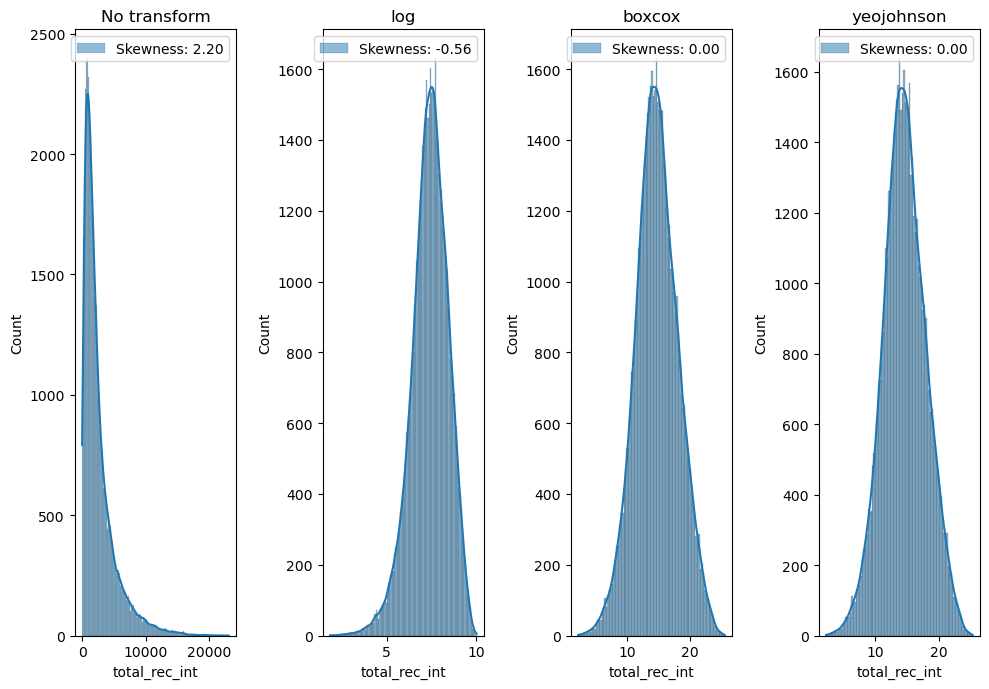

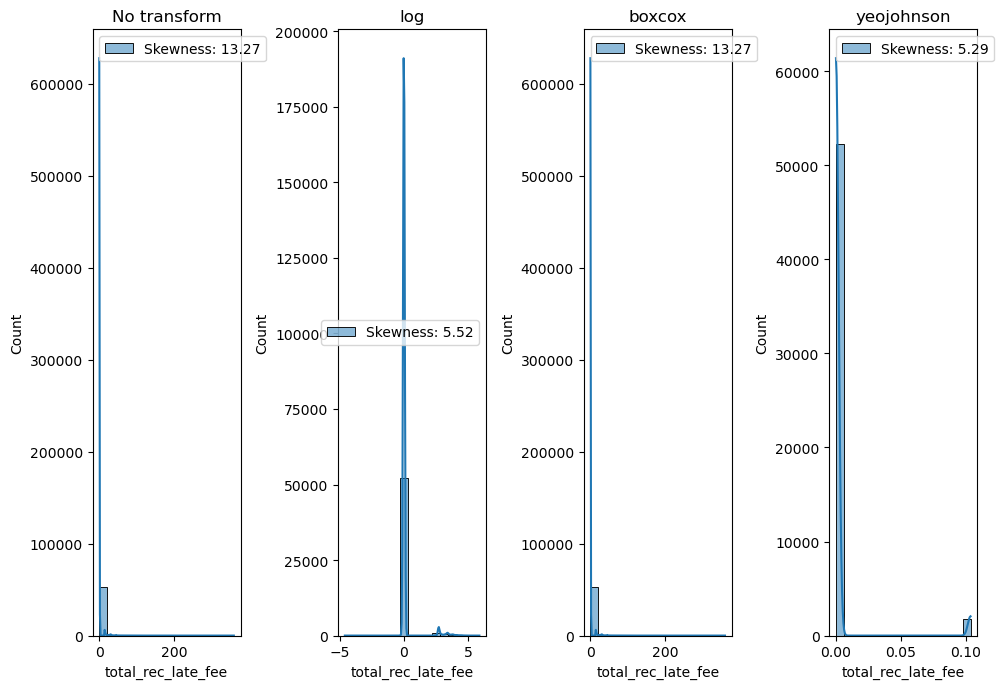

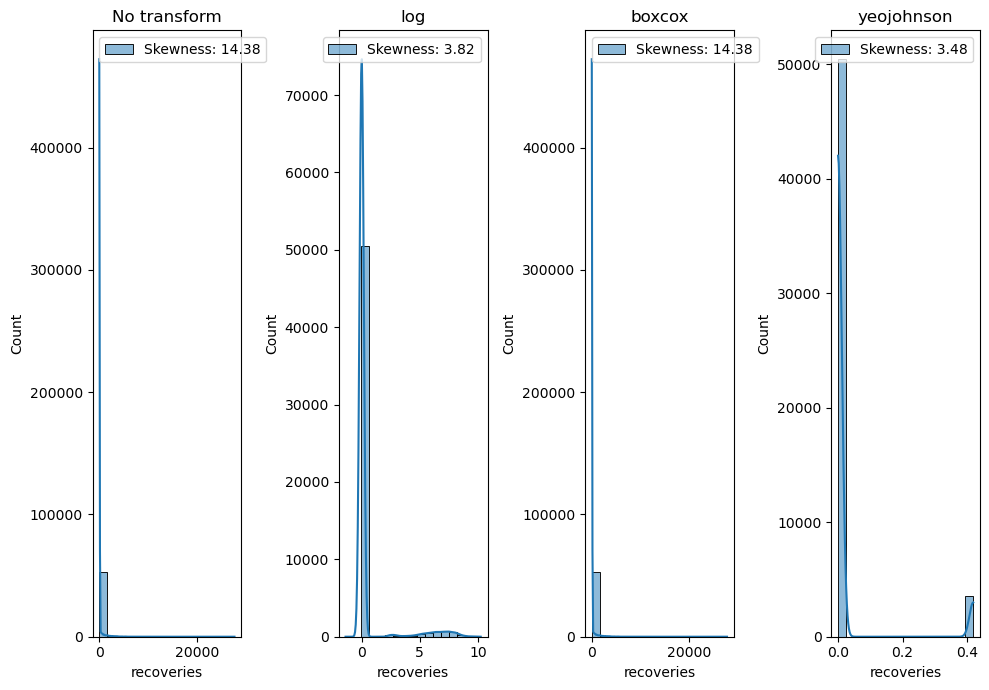

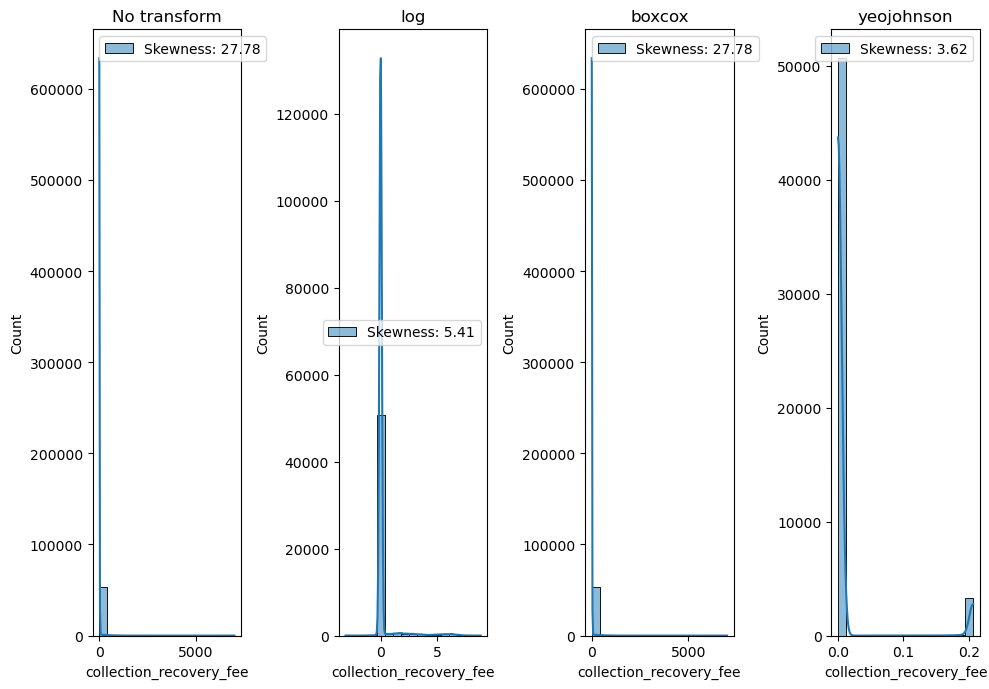

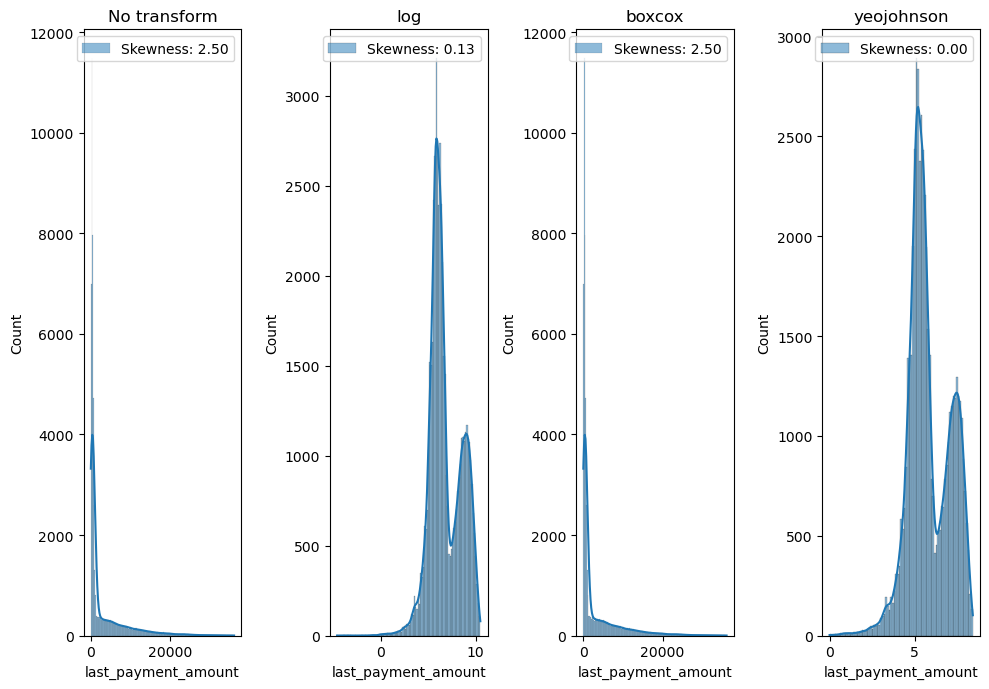

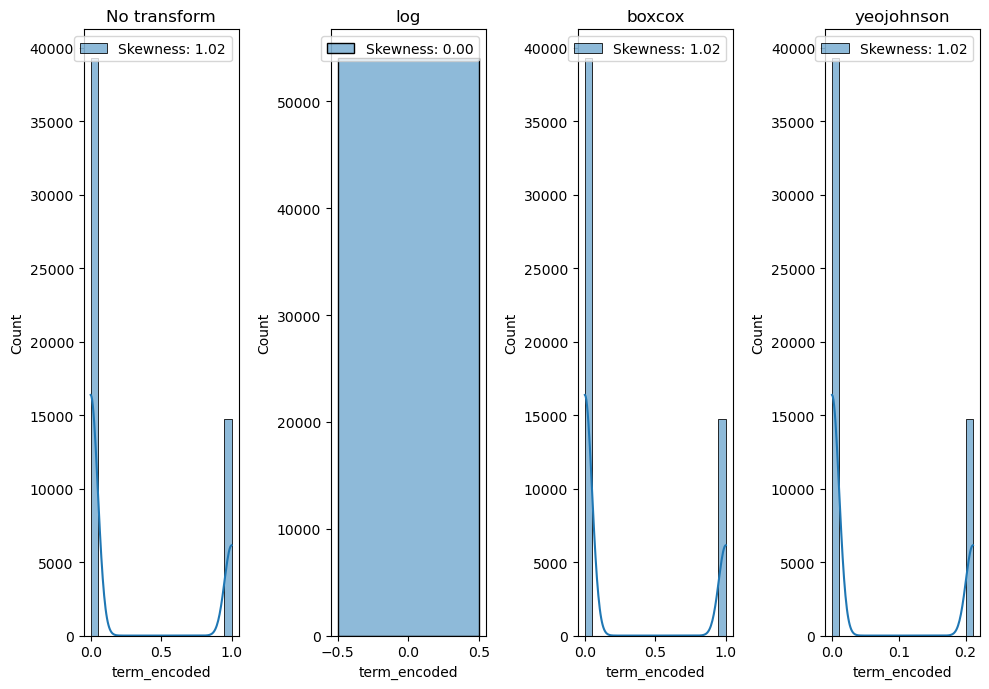

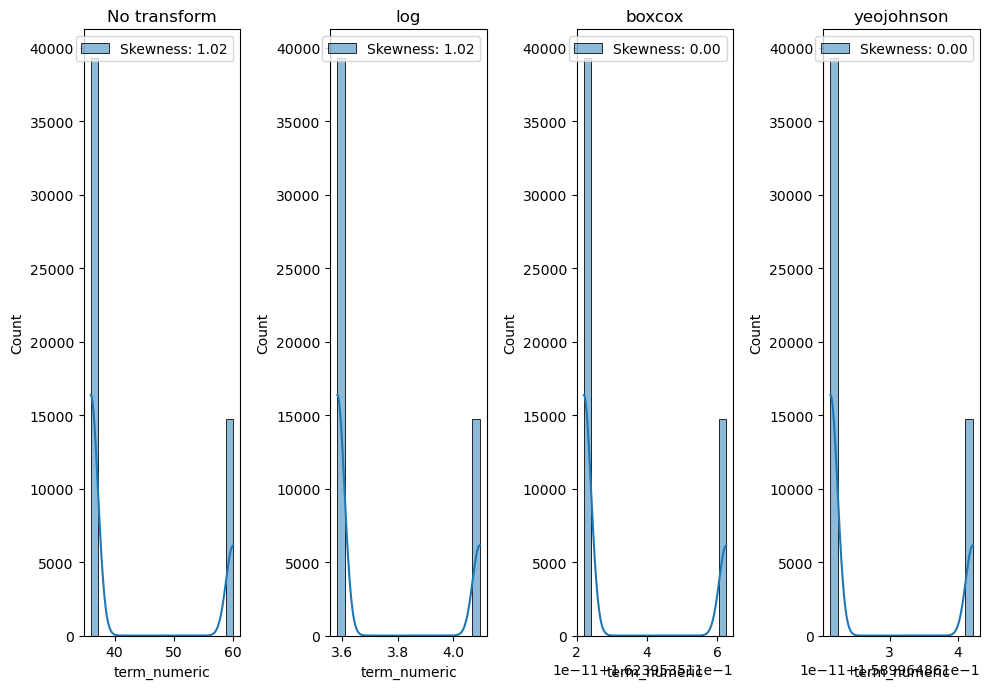

In [16]:
all_skewed.remove('member_id')
all_skewed.remove('id')
for col in all_skewed:
    plotter.TransformTest(df, col=col)


#%%[markdown]
# Several variables look normal under the Yeo Johnson transformation:
# *loan_amount, funded_amount, funded_amount_inv, instalment, annual_inc, open_accounts, total_accounts, total_payment, total_payment_inv, total_rec_prncp, total_rec_int*
# We add columns for each of these with the YJ transformation applied.
# The other variables are not amenable to transformation, and are often bimodal, so we leave these untouched. 

In [17]:
to_transform = ['loan_amount', 'funded_amount', 'funded_amount_inv', 'instalment', 'annual_inc', 'open_accounts', 'total_accounts', 'total_payment', 'total_payment_inv', 'total_rec_prncp', 'total_rec_int']
for col in to_transform:
    new_col = col + '-yc'
    df[new_col] = pd.Series(stats.yeojohnson(df[col])[0]).rename(new_col, inplace=True)

df.info()

#%%[markdown]
# Next we visualise, identify, and remove outliers.
# As a threshold, we remove outliers that are more extreme than 3 standard deviations from the mean.
# We need an approximately normal distribution to apply the zscore criteria, so we use only columns which we performed the YC transformation on.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54036 entries, 0 to 54035
Data columns (total 53 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   index                       54036 non-null  int64         
 1   id                          54036 non-null  int64         
 2   member_id                   54036 non-null  int64         
 3   loan_amount                 54036 non-null  int64         
 4   funded_amount               54036 non-null  float64       
 5   funded_amount_inv           54036 non-null  float64       
 6   term                        54036 non-null  category      
 7   int_rate                    54036 non-null  float64       
 8   instalment                  54036 non-null  float64       
 9   grade                       54036 non-null  category      
 10  sub_grade                   54036 non-null  category      
 11  employment_length           54036 non-null  category  

<class 'pandas.core.frame.DataFrame'>
Index: 53165 entries, 0 to 54035
Data columns (total 53 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   index                       53165 non-null  int64         
 1   id                          53165 non-null  int64         
 2   member_id                   53165 non-null  int64         
 3   loan_amount                 53165 non-null  int64         
 4   funded_amount               53165 non-null  float64       
 5   funded_amount_inv           53165 non-null  float64       
 6   term                        53165 non-null  category      
 7   int_rate                    53165 non-null  float64       
 8   instalment                  53165 non-null  float64       
 9   grade                       53165 non-null  category      
 10  sub_grade                   53165 non-null  category      
 11  employment_length           53165 non-null  category      


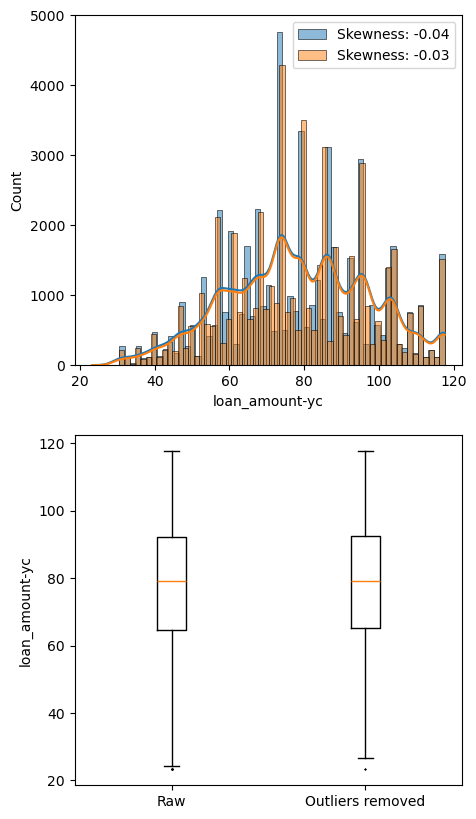

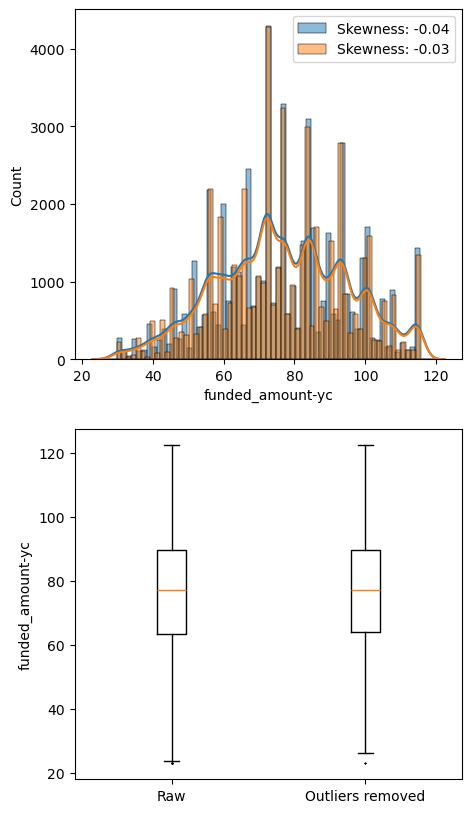

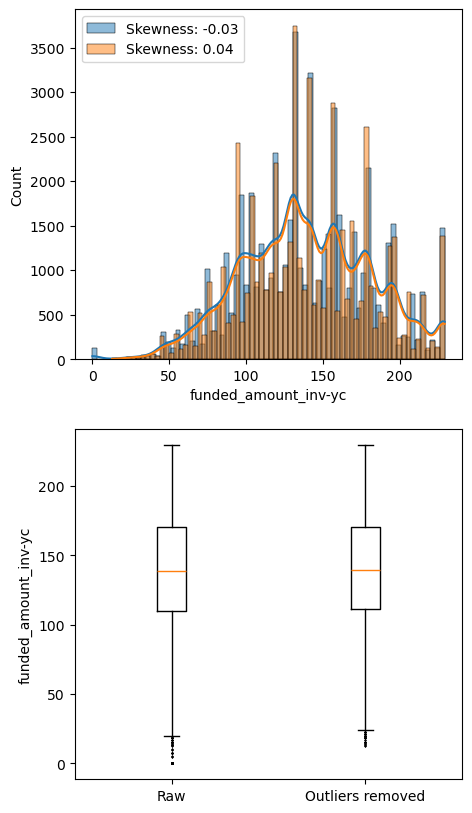

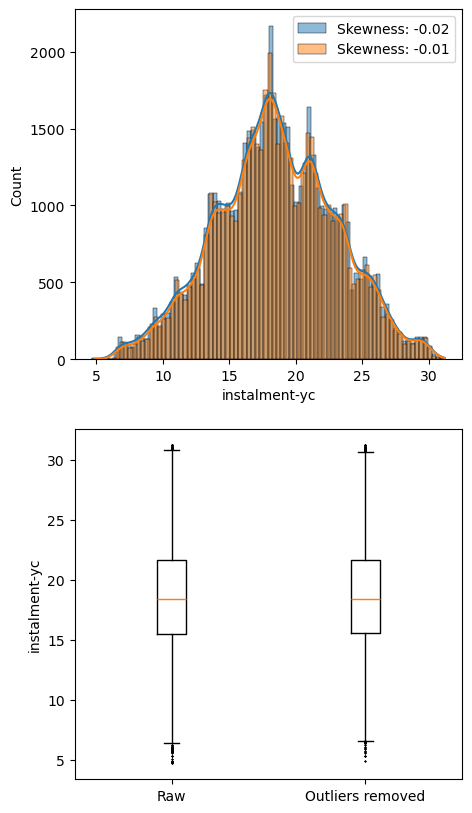

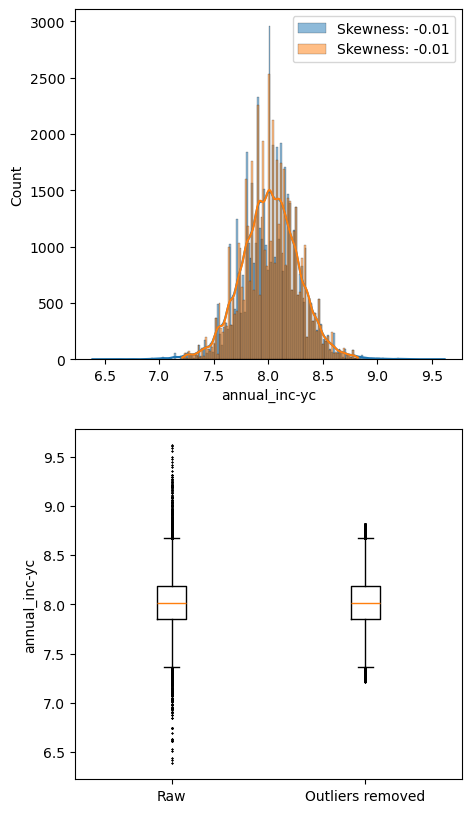

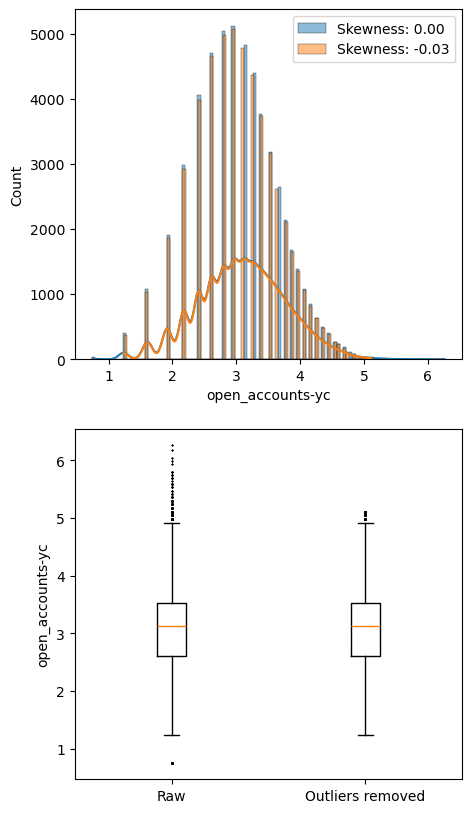

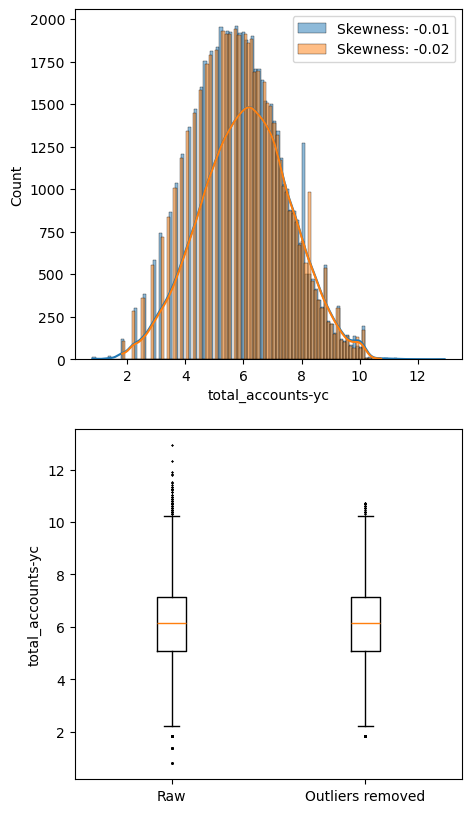

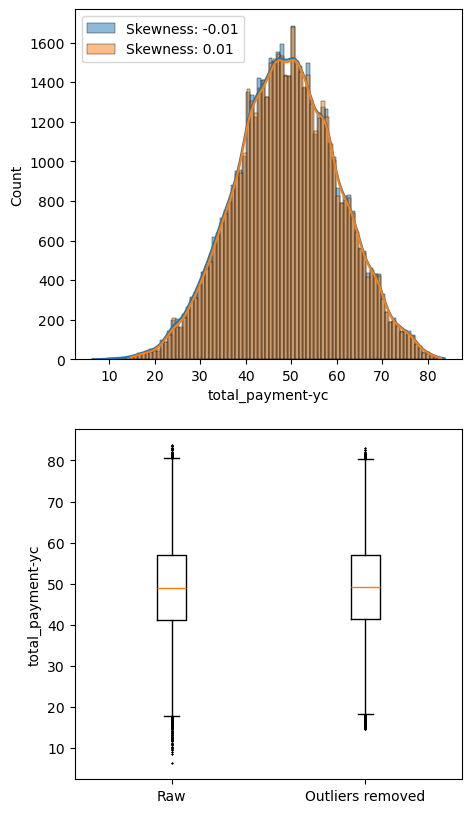

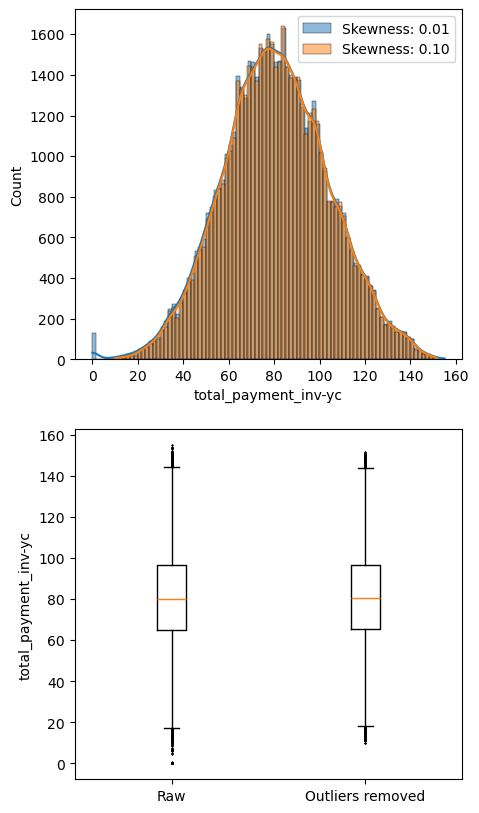

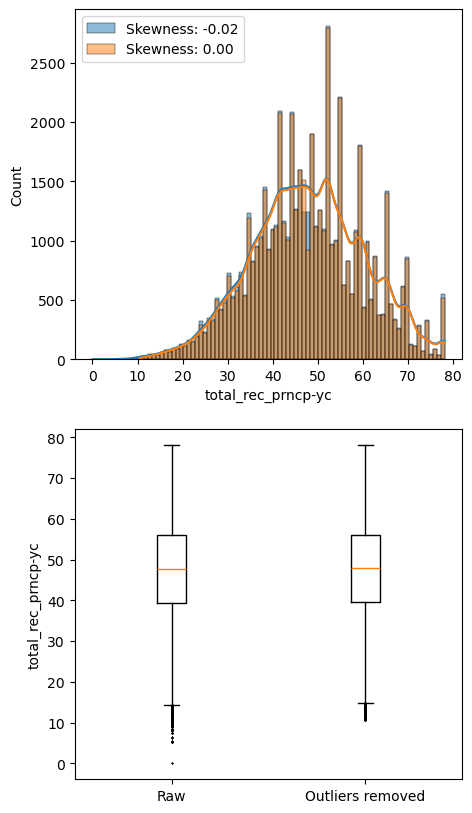

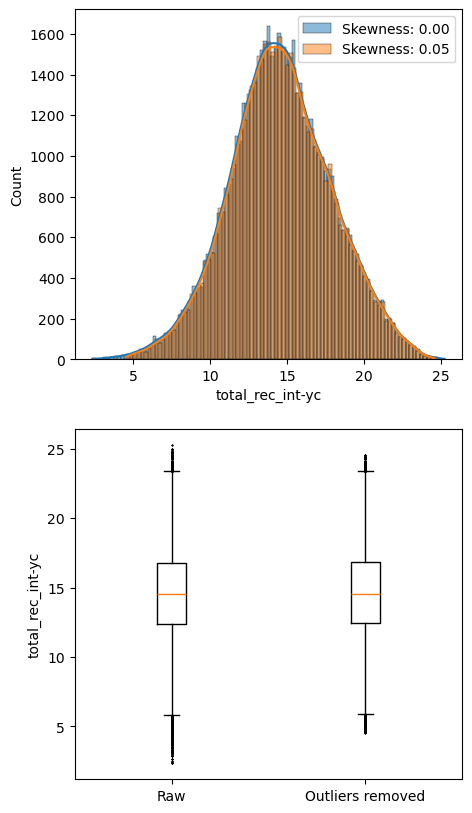

In [18]:
to_check_outliers = [tt + '-yc' for tt in to_transform]
rows_with_no_outliers = (np.abs(stats.zscore(df[to_check_outliers])) < 3).all(axis=1)
df_test = df[rows_with_no_outliers]
df_test.info()

plotter.CheckOutlierRemoval(df, df_test, to_check_outliers)
#%%[markdown]

# We see that the oulier quality control step removed less than 2% of the data.
# Histograms are similar before and after removal, and we see fewer outlier in the box and whisker plots.
# We therefore go ahead and overwrite df with df_test, which has the outlier removed.

In [19]:
print('%s %% of data removed as outliers.' % (100*(len(df)-len(df_test))/len(df)))
df = df_test

#%%[markdown]

1.6118883707158191 % of data removed as outliers.


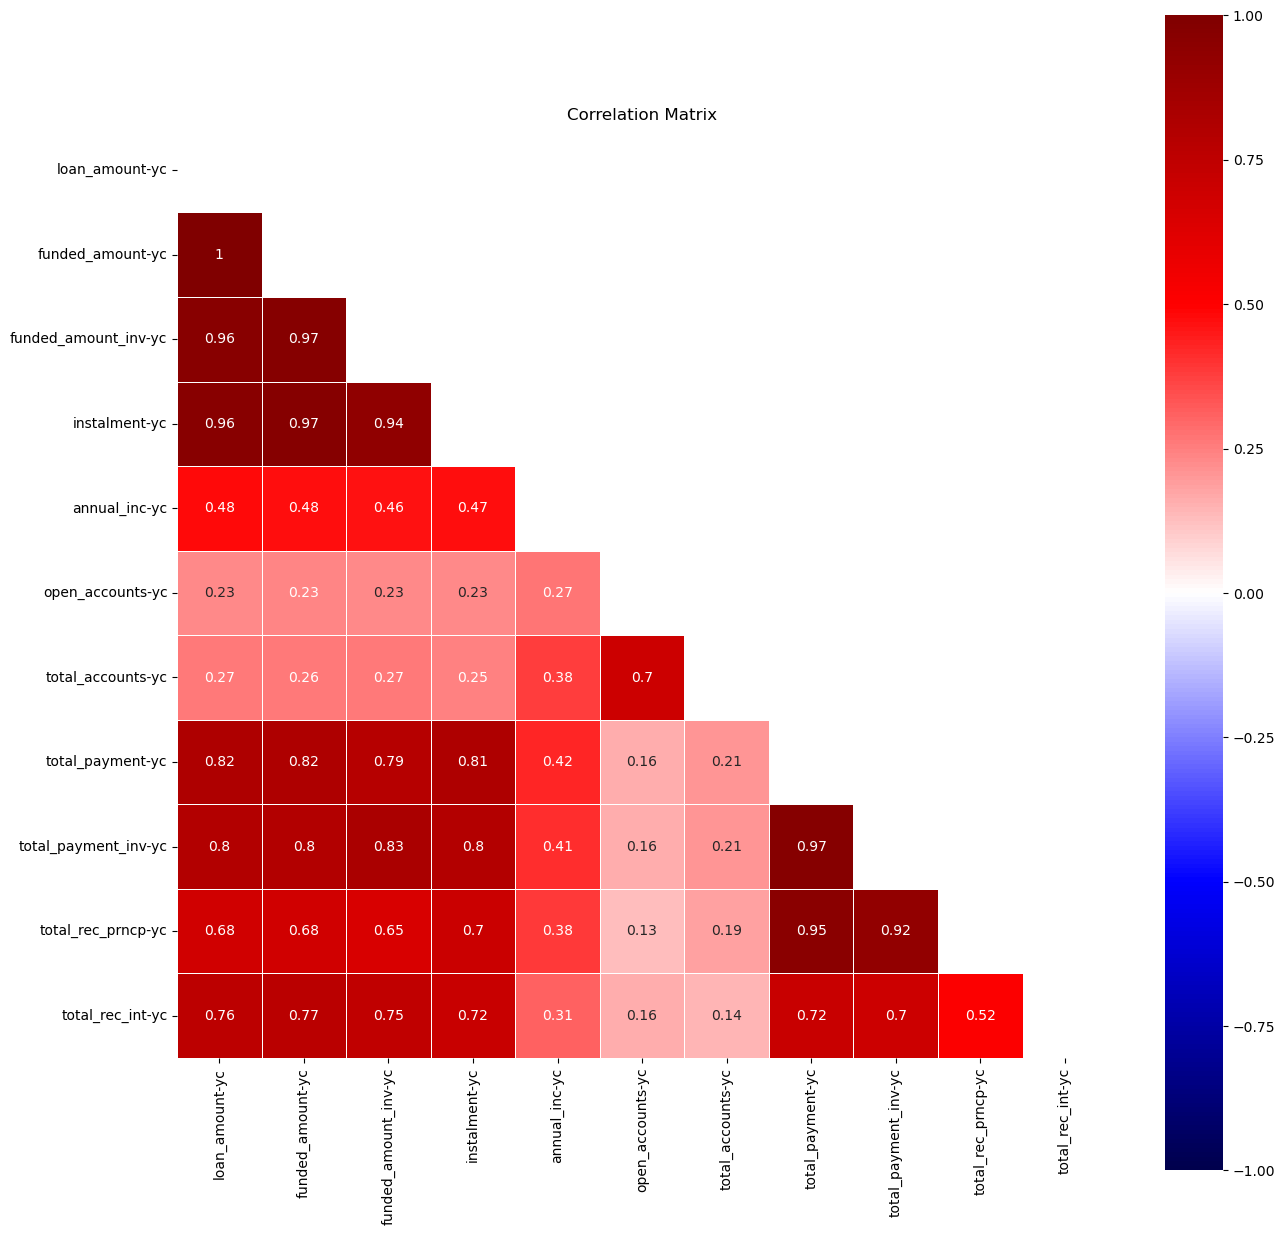

In [20]:
# Next, we check for correlation between columns with approximately normal data.
plotter.CorrelationHeatmap(df, to_check_outliers)

#%%[markdown]
# Several variable pairs have correlations > 0.9, with some rounding off to 1.
# Rather than dropping variables now, we will use this figure as a reference during the analysis step.
#
# Finally, we save the dataframe to a csv for loading in the analysis step.

In [21]:
data_transform.DropOnly1Value(df)
print(df.info())
df.to_csv('../data/loan_payments-clean.csv')
df.to_pickle('../data/loan_payments-clean.pkl')

<class 'pandas.core.frame.DataFrame'>
Index: 53165 entries, 0 to 54035
Data columns (total 51 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   index                       53165 non-null  int64         
 1   id                          53165 non-null  int64         
 2   member_id                   53165 non-null  int64         
 3   loan_amount                 53165 non-null  int64         
 4   funded_amount               53165 non-null  float64       
 5   funded_amount_inv           53165 non-null  float64       
 6   term                        53165 non-null  category      
 7   int_rate                    53165 non-null  float64       
 8   instalment                  53165 non-null  float64       
 9   grade                       53165 non-null  category      
 10  sub_grade                   53165 non-null  category      
 11  employment_length           53165 non-null  category      
